# Description
The idea is to use previous observation to identify trends, patterns (maybe shape of indicators) when users want to sell or buy

In [1]:
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import random

In [229]:
sequence = 50
target_name = "target_2_m"

In [230]:


df_all = pd.read_feather("../data/training/training_all_crypto_14_12_2021.feather")
df_xlm = df_all[df_all.pair_name=="xlmeur"].copy()
df_xlm[target_name] = df_xlm["target_2"]*1000

In [231]:
df = df_xlm.copy()
features = [col for col in df.columns if col.startswith("feature_domain")]
targets = [col for col in df.columns if col.startswith("target")]
print("features length", len(features))
print("target length", len(targets))
df[features] = (df[features]-df[features].mean())/ df[features].std()

features length 38
target length 9


The idea is to create a datframe with sequences that can be converted into image

In [190]:
print(df.shape)

(117948, 144)


In [232]:
df_val = df.loc[100000:].copy()
df_train = df.loc[:100000].copy()

In [233]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target_name])

In [234]:
def create_sequence(X, y, sequence_length=10):
    m, n = X.shape
    
    #y_shape = 1 f len(y.shape) ==1 else y.shape[1]
    #targets = np.zeros((m-sequence_length, y.shape[1]))
    targets = np.zeros((m-sequence_length,))
    out = np.zeros((m-sequence_length, sequence_length, n))
    for i in range(m-sequence_length):        
        out[i, :,:] = X[i:i+sequence_length, : ] 
        #targets[i, :] = y[i+sequence_length,:]
        targets[i] = y[i+sequence_length]
        
        
    return out, targets

In [235]:
target.shape

(74900,)

In [236]:
# we have to use std-scalar!!
X_out, target = create_sequence(X=X_train.values, y=y_train.values, sequence_length=sequence)

In [237]:
X_out_test, target_test = create_sequence(X=X_test.values, y=y_test.values, sequence_length=sequence)

0.0


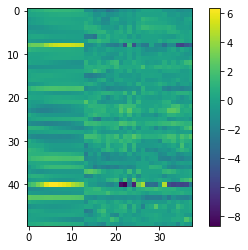

In [251]:
print(target[3])
plt.imshow(X_out[1,:,:])
plt.colorbar()

In [239]:
class NN(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NN, self).__init__()
        self.l1 = torch.nn.Linear(dim_in,50)
        self.l2 = torch.nn.Linear(50, dim_out)
    def forward(self, x):
        x = torch.nn.functional.relu(self.l1(x))
        x = self.l2(x)
        return x   
        

In [240]:
batch_size = 24
epochs = 10
model = NN(dim_in=sequence*38, dim_out=1)

In [241]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [242]:
X_out_val, target_val = create_sequence(X=df_val[features].values, y=df_val[target_name].values, sequence_length=sequence)
X_val_torch = torch.Tensor(X_out_val[:batch_size].reshape(-1,38*sequence))
y_val_torch = torch.Tensor(target_val[:batch_size])

In [243]:
loss_train_list = []
loss_test_list = []

In [244]:

y_test_torch = torch.Tensor(target_test[:batch_size].reshape(-1,1))
X_test_torch= torch.Tensor(X_out_test[:batch_size].reshape(-1,38*sequence))
for epoch in range(epochs):
    
    for n in range(round(100000/(batch_size+1))):
        sampl = np.random.randint(0,len(X_out), size=batch_size)
        X = torch.Tensor(X_out[sampl].reshape(batch_size, -1))
        y = torch.Tensor(target[sampl].reshape(-1,1))
        optim.zero_grad()
        output = model(X)
        #print(output.shape)
        #print(y.shape)
        loss = criterion(output, y)
        loss.backward()
        optim.step()
        loss_train_list.append(loss.detach().numpy())
        loss_test = criterion(model(X_test_torch), y_test_torch)
        loss_test_list.append(loss_test.detach().numpy())
    
    print(epoch, loss.mean(), loss_test.mean())
    # validation


    #plt.plot(model(X_val_torch).detach().numpy(), label="preds")
    #plt.plot(y_val_torch, label="true")
    #plt.legend()
    #plt.show()

0 tensor(4.1348, grad_fn=<MeanBackward0>) tensor(2.9413, grad_fn=<MeanBackward0>)
1 tensor(1.3210, grad_fn=<MeanBackward0>) tensor(2.7513, grad_fn=<MeanBackward0>)
2 tensor(3.7569, grad_fn=<MeanBackward0>) tensor(2.8685, grad_fn=<MeanBackward0>)
3 tensor(1.8152, grad_fn=<MeanBackward0>) tensor(3.4193, grad_fn=<MeanBackward0>)
4 tensor(3.8122, grad_fn=<MeanBackward0>) tensor(3.5449, grad_fn=<MeanBackward0>)
5 tensor(2.8675, grad_fn=<MeanBackward0>) tensor(3.2350, grad_fn=<MeanBackward0>)
6 tensor(1.3320, grad_fn=<MeanBackward0>) tensor(3.6158, grad_fn=<MeanBackward0>)
7 tensor(2.6794, grad_fn=<MeanBackward0>) tensor(3.7931, grad_fn=<MeanBackward0>)
8 tensor(1.6026, grad_fn=<MeanBackward0>) tensor(3.2637, grad_fn=<MeanBackward0>)
9 tensor(1.6429, grad_fn=<MeanBackward0>) tensor(4.1102, grad_fn=<MeanBackward0>)


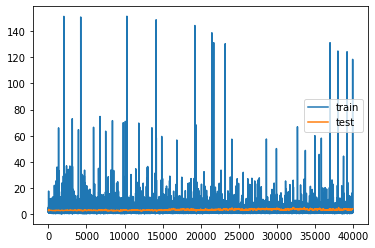

In [248]:
plt.plot(loss_train_list, label="train")
plt.plot(loss_test_list, label="test")
plt.legend()

Corr: 0.009947243385788616


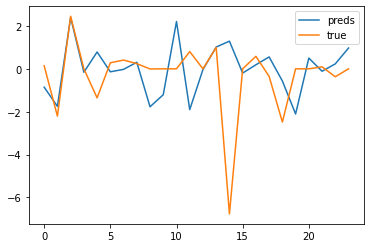

In [249]:
print("Corr:", pd.DataFrame({"preds": model(X_test_torch).detach().numpy().reshape(-1), "true":y_test_torch.detach().numpy().reshape(-1)}).corr()["preds"]["true"])
plt.plot(model(X_test_torch).detach().numpy(), label="preds")
plt.plot(y_test_torch, label="true")
plt.legend()

Corr: 0.10835037370556004


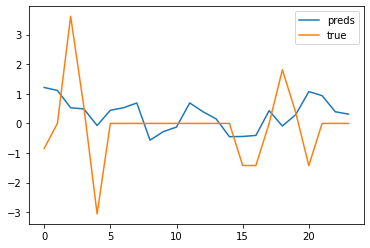

In [250]:
# validation
X_out_val, target_val = create_sequence(X=df_val[features].values, y=df_val[target_name].values, sequence_length=sequence)
X_val_torch = torch.Tensor(X_out_val[:batch_size].reshape(-1,38*sequence))
y_val_torch = torch.Tensor(target_val[:batch_size])

y_preds = model(X_val_torch).detach().numpy().reshape(-1)
y_true = y_val_torch.detach().numpy().reshape(-1)
plt.plot(y_preds, label="preds")
plt.plot(y_true, label="true")
plt.legend()
print("Corr:", pd.DataFrame({"preds": y_preds, "true":y_true}).corr()["preds"]["true"])

In [179]:
for epoch in range(epochs):
    
    for n in range(round(100000/(batch_size+1))):
        #try:
        X = torch.Tensor(X_out[n*batch_size:(n+1)*batch_size, :,:].reshape(batch_size, -1))
        y = torch.Tensor(target[n*batch_size:(n+1)*batch_size])#.reshape(batch_size))
        #X = torch.Tensor(X_out[n*batch_size:(n+1)*batch_size, :,:])
        #y = torch.Tensor(target[n*batch_size:(n+1)*batch_size,:]) 
        optim.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        #print(output.shape, y.shape)
        loss.backward()
        optim.step()
        #except ValueError:
        #    print(n)
        #    break
    
    print(epoch, loss.mean())
    
    
    

/Users/pablocanadapereira/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x1710 and 1900x100)

In [72]:
model(torch.Tensor(X_out_test[0, :,:].reshape(1,-1)))

tensor([[-0.0180,  0.0032,  0.0055,  0.0070,  0.0035,  0.0151, -0.0060, -0.0015]],
       grad_fn=<AddmmBackward0>)

In [73]:
target_test[0,:]

array([ 0.00013795,  0.00013795,  0.00396958,  0.00243199, -0.00084806,
       -0.01078218, -0.01284392, -0.01082717])

In [ ]:
df[features].values[]

In [ ]:
model(torch.Tensor(X_out[0, :,:].reshape(1,-1)))

In [ ]:
target[0,:]

In [21]:
df.columns

Index(['index', 'Unnamed: 0', 'date', 'time', 'open', 'high', 'low', 'close',
       'vwap', 'volume',
       ...
       'feature_domain_30', 'feature_domain_31', 'feature_domain_32',
       'feature_domain_33', 'feature_domain_34', 'feature_domain_35',
       'feature_domain_36', 'feature_domain_37', 'type', 'pair_name'],
      dtype='object', length=143)

<AxesSubplot:xlabel='feature_domain_13', ylabel='Count'>

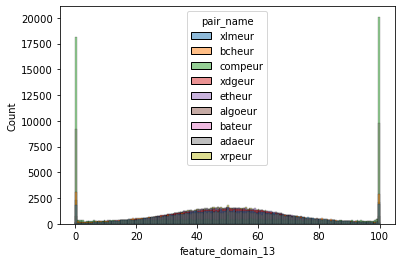

In [26]:
sns.histplot(data=df, x="feature_domain_13", hue="pair_name")

array([0.00073525])

In [34]:
for feature in features:
    std = df[[feature, "pair_name"]].groupby("pair_name").std().std()
    print(std )
    if std.values[0]>1:
        print(df[[feature, "pair_name"]].groupby("pair_name").std())

feature_domain_0    0.000735
dtype: float64
feature_domain_1    0.001044
dtype: float64
feature_domain_2    0.001262
dtype: float64
feature_domain_3    0.00144
dtype: float64
feature_domain_4    0.001964
dtype: float64
feature_domain_5    0.002357
dtype: float64
feature_domain_6    0.002695
dtype: float64
feature_domain_7    0.003001
dtype: float64
feature_domain_8    0.003285
dtype: float64
feature_domain_9    0.00355
dtype: float64
feature_domain_10    0.00425
dtype: float64
feature_domain_11    0.004741
dtype: float64
feature_domain_12    0.005166
dtype: float64
feature_domain_13    6.842973
dtype: float64
           feature_domain_13
pair_name                   
adaeur             17.074042
algoeur            22.214237
bateur             29.227444
bcheur             23.662634
compeur            37.143334
etheur             16.844191
xdgeur             18.773776
xlmeur             21.478258
xrpeur             16.405344
feature_domain_14    6.18821
dtype: float64
           feature_d